In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score
traction=1e5 
E=2e8
L =100 # mm
nu=0.3
qx=0
qy=0
square = dde.geometry.Rectangle([0, 0], [L, L])
geom = square


# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0
def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L
def boundary_left(x, on_boundary):
    return on_boundary and x[0]==0
def boundary_right(x, on_boundary):
    return on_boundary and x[0]==L


def traction_top(x, y,X):
 

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    T_x = sigma_xy  # Since n_x = 0, T_x = σ_xy n_y
    T_y = sigma_yy  # Since n_y = 1, T_y = σ_yy n_y

    # Desired traction
    T_x_desired = 0
    T_y_desired = traction  # 1e5 Pa
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired    


    residuals = tf.concat([T_x - T_x_desired, T_y - T_y_desired], axis=1)
    return [T_x - T_x_desired, T_y - T_y_desired]

bc_point_origin = dde.DirichletBC(
    geom,
    lambda x: 0,
    lambda x, on_boundary: np.isclose(x[0], 0) and np.isclose(x[1], 0),
    component=0  # Fix u_x
)
bc_point_origin_y = dde.DirichletBC(
    geom,
    lambda x: 0,
    lambda x, on_boundary: np.isclose(x[0], 0) and np.isclose(x[1], 0),
    component=1  # Fix u_y
)

# Constraint at (L, 0) to prevent rotation
bc_point_edge = dde.DirichletBC(
    geom,
    lambda x: 0,
    lambda x, on_boundary: np.isclose(x[0], L) and np.isclose(x[1], 0),
    component=0  # Fix u_x
)
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma=dde.OperatorBC(geom, traction_top, boundary_top)


def pde(x, y):
    
    ux=y[:,0:1]
    uy=y[:,1:2]

    C = (E / (1 - nu**2)) * np.array([[1, nu, 0],
                                      [nu, 1, 0],
                                      [0, 0, (1 - nu) / 2]])
    
    duxdx=dde.grad.jacobian(y,x,i=0,j=0)
    duxdy=dde.grad.jacobian(y,x,i=0,j=1)
    duydx=dde.grad.jacobian(y,x,i=1,j=0)
    duydy=dde.grad.jacobian(y,x,i=1,j=1)
    #Strain
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Constitutive relations residuals
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy
    
    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    
    return [eq1, eq2]

data = dde.data.PDE(
    geom,
    pde, [bc_top_sigma,bc_point_edge,bc_point_origin,bc_point_origin_y],
    num_domain=800,
    num_boundary=800,
    num_test=700,
    )

# Network for C_L
layer_size = [2] + [40] * 5 + [2]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4, loss_weights=[1, 1, 1, 1e10, 1e10,1,1,1])
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=200000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


KeyboardInterrupt: 

Compiling model...
Building feed-forward neural network...
'build' took 0.115452 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.968216 s

Training model...

0         [2.05e+11, 3.69e+11, 3.11e-02, 6.52e-02, 1.16e+12]    [1.42e+11, 8.76e+10, 3.11e-02, 6.52e-02, 1.16e+12]    []  
1000      [4.40e+10, 3.04e+10, 3.29e-03, 6.31e-03, 1.03e+11]    [5.07e+10, 3.56e+10, 3.29e-03, 6.31e-03, 1.03e+11]    []  
2000      [2.16e+10, 1.63e+10, 2.60e-03, 8.86e-03, 3.76e+10]    [2.72e+10, 2.15e+10, 2.60e-03, 8.86e-03, 3.76e+10]    []  
3000      [1.19e+10, 8.95e+09, 3.42e-03, 6.18e-03, 1.75e+10]    [1.59e+10, 1.19e+10, 3.42e-03, 6.18e-03, 1.75e+10]    []  
4000      [6.85e+09, 4.94e+09, 4.02e-03, 3.16e-03, 7.90e+09]    [9.81e+09, 6.41e+09, 4.02e-03, 3.16e-03, 7.90e+09]    []  
5000      [4.13e+09, 2.89e+09, 4.04e-03, 1.21e-03, 3.28e+09]    [6.36e+09, 3.79e+09, 4.04e-03, 1.21e-03, 3.28e+09]    []  
6000      [2.58e+09, 1.82e+09, 3.52e-03, 7.95e-04, 1.34e+09]    [4.28e+09, 2.70e+09, 3.52e-03, 7.95e-04, 1.34e+09]    []  
7000      [1.59e+09, 1.21e+09, 2.71e-03, 1.37e-03, 6.25e+08]    [2.92e+09, 2.30e+09, 2.71e-03

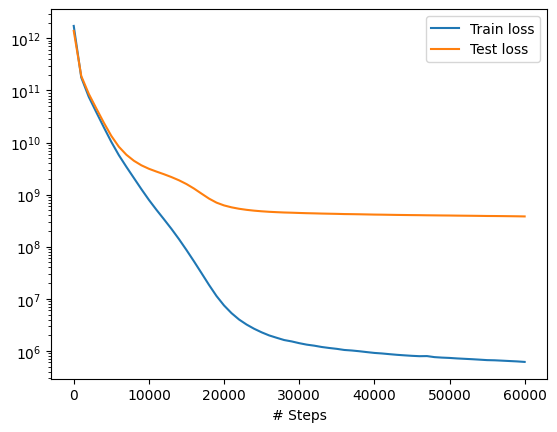

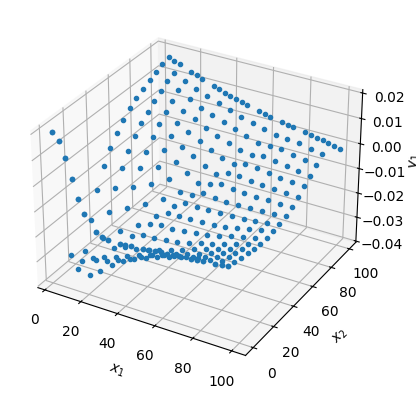

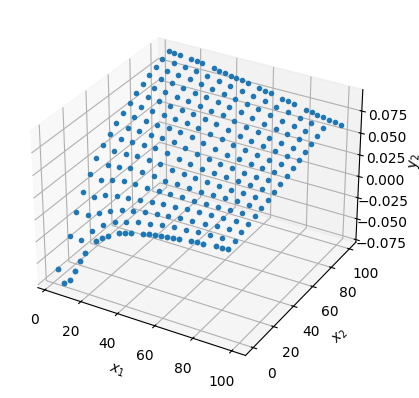

In [27]:
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
traction = 1e5
E = 2e8
L = 100  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

def boundary_left(x, on_boundary):
    return on_boundary and x[0]==0

def boundary_right(x, on_boundary):
    return on_boundary and x[0]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)

# Point constraints to prevent rigid body motion
bc_point_origin = dde.icbc.DirichletBC(
    geom,
    lambda x: 0,
    [boundary_bottom,boundary_left],
    component=0  # Fix u_x
)
bc_point_origin_y = dde.icbc.DirichletBC(
    geom,
    lambda x: 0,
    [boundary_bottom,boundary_left],
    component=1  # Fix u_y
)
bc_point_edge = dde.icbc.DirichletBC(
    geom,
    lambda x: 0,
    [boundary_bottom,boundary_right],
    component=0  # Fix u_x
)

# Top traction boundary condition
def traction_top(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    n_x = 0  # Top edge normal vector
    n_y = 1

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = traction

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    residuals = tf.concat([T_x_residual, T_y_residual], axis=1)
    return residuals

bc_top_sigma = dde.OperatorBC(geom, traction_top, boundary_top)

# Left traction-free boundary condition
def traction_left(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on left boundary
    n_x = -1  # Left edge normal vector
    n_y = 0

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = 0

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    residuals = tf.concat([T_x_residual, T_y_residual], axis=1)
    return residuals

bc_left_traction = dde.OperatorBC(geom, traction_left, boundary_left)

# Right traction-free boundary condition
def traction_right(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on right boundary
    n_x = 1  # Right edge normal vector
    n_y = 0

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = 0

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    
    return [T_x_residual,T_y_residual]

bc_right_traction = dde.OperatorBC(geom, traction_right, boundary_right)

# Define the PDE
def pde(x, y):
    ux = y[:, 0:1]
    uy = y[:, 1:2]

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
   
    d2eps_xx_dy2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.jacobian(gamma_xy, x, i=0, j=1)
    # Stress components
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)

    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    return [eq1, eq2]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma
    ],
    num_domain=100,
    num_boundary=100,
    num_test=200,
)

# Neural network
net = dde.maps.FNN([2] + [300] * 10 + [2], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam", lr=1e-7, loss_weights=[1, 1,1, 1, 1])

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.095066 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.609115 s

Training model...

0         [6.01e-05, 3.89e-04, 1.33e+13, 1.07e+13, 6.10e+11, 3.76e-01, 3.41e-04, 4.39e+11]    [4.41e-05, 1.10e-04, 1.01e+13, 5.21e+12, 8.30e+11, 3.76e-01, 3.41e-04, 4.39e+11]    []  
1000      [8.40e-05, 3.71e-04, 2.48e+12, 1.04e+12, 2.43e+11, 4.02e-02, 1.36e-03, 1.62e+11]    [4.44e-05, 1.11e-04, 3.04e+12, 9.40e+11, 2.32e+11, 4.02e-02, 1.36e-03, 1.62e+11]    []  
2000      [8.90e-05, 3.72e-04, 8.35e+11, 2.44e+11, 1.72e+11, 2.14e-02, 8.97e-04, 8.02e+10]    [4.30e-05, 1.07e-04, 9.86e+11, 2.91e+11, 1.87e+11, 2.14e-02, 8.97e-04, 8.02e+10]    []  
3000      [8.98e-05, 3.78e-04, 3.02e+11, 1.01e+11, 1.14e+11, 1.71e-02, 8.07e-04, 3.96e+10]    [4.11e-05, 1.03e-04, 2.92e+11, 1.35e+11, 1.23e+11, 1.71e-02, 8.07e-04, 3.96e+10]    []  
4000      [9.02e-05, 3.89e-04, 1.17e+11, 5.32e+10, 6.63e+10, 1.09e-02, 7.31e-04, 2.04e+10]    [4.01e-05, 1.01e-04, 9.52e+10, 7.12e+10, 6.95e+10, 1.09e-02, 7.31e-04, 2.04e+10]    []  
5000      [9.06e-05, 3.99e-04, 5.08e+10

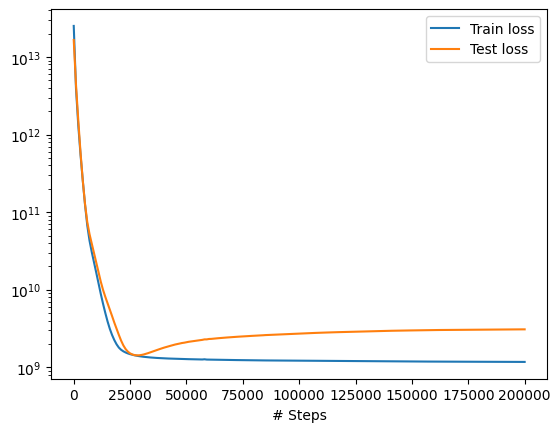

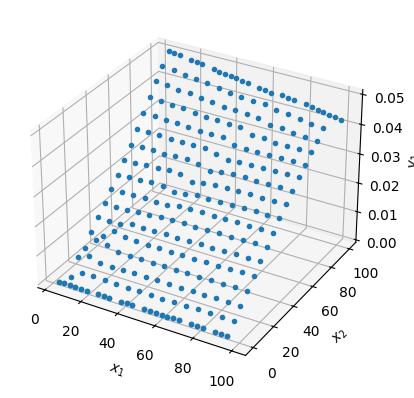

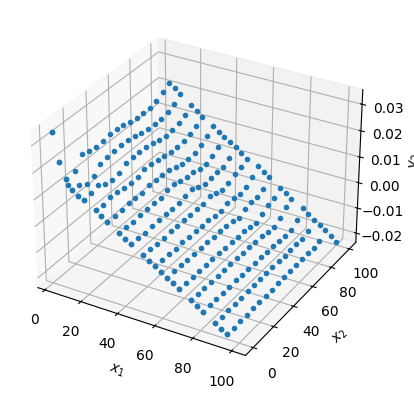

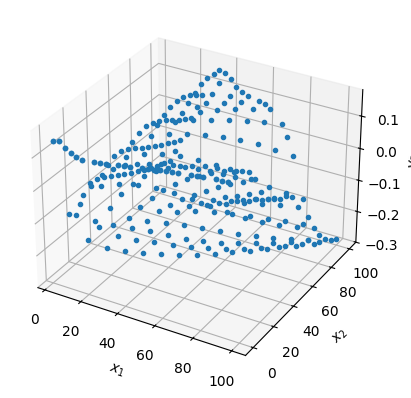

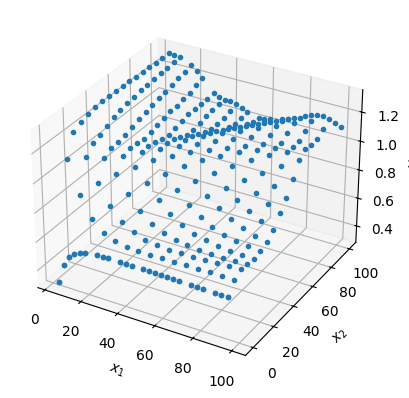

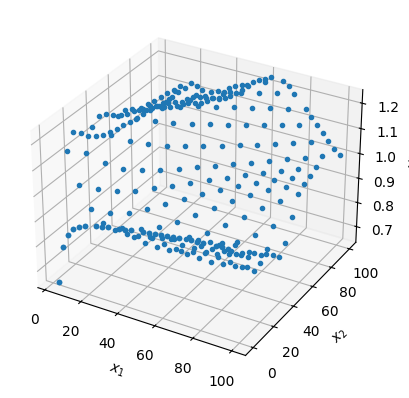

In [22]:
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
traction = 1e5
E = 2e8
L = 100  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

def boundary_left(x, on_boundary):
    return on_boundary and x[0]==0

def boundary_right(x, on_boundary):
    return on_boundary and x[0]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)

# Top traction boundary condition
def traction_top(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    n_x = 0  # Top edge normal vector
    n_y = 1

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = traction

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    residuals = tf.concat([T_x_residual, T_y_residual], axis=1)
    return residuals

bc_top_sigma = dde.OperatorBC(geom, traction_top, boundary_top)
bc_top_sigma_yy = dde.icbc.DirichletBC(geom, lambda x: traction, boundary_top, component=3)

# Left traction-free boundary condition
def traction_left(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on left boundary
    n_x = -1  # Left edge normal vector
    n_y = 0

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = 0

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    residuals = tf.concat([T_x_residual, T_y_residual], axis=1)
    return residuals

bc_left_traction = dde.OperatorBC(geom, traction_left, boundary_left)

# Right traction-free boundary condition
def traction_right(inputs, outputs, X):
    x = inputs
    y = outputs

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Stress components
    sigma_xx = (E / (1 - nu**2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu**2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on right boundary
    n_x = 1  # Right edge normal vector
    n_y = 0

    T_x = sigma_xx * n_x + sigma_xy * n_y
    T_y = sigma_xy * n_x + sigma_yy * n_y

    # Desired tractions
    T_x_desired = 0
    T_y_desired = 0

    # Residuals
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired

    # Ensure consistent dimensions
    T_x_residual = tf.reshape(T_x_residual, [-1, 1])
    T_y_residual = tf.reshape(T_y_residual, [-1, 1])

    
    return [T_x_residual,T_y_residual]

bc_right_traction = dde.OperatorBC(geom, traction_right, boundary_right)

# Define the PDE
def pde(x, y):
    ux = y[:, 0:1]
    uy = y[:, 1:2]
    sigma_xx=y[:,2:3]
    sigma_yy=y[:,3:4]
    sigma_xy=y[:,4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
   
    d2eps_xx_dy2 = dde.grad.hessian(y, x,  i=0, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(y, x,  i=1, j=0)
    d2eps_xy_dxdy = dde.grad.jacobian(gamma_xy, x, i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)

    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4=sigma_xx-(E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5=sigma_yy-(E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6=sigma_xy-(E / (2 * (1 + nu))) * gamma_xy
    return [eq1, eq2, eq4, eq5,eq6]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma
    ],
    num_domain=100,
    num_boundary=100,
    num_test=200,
)

# Neural network
net = dde.maps.FNN([2] + [300] * 10 + [5], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam", lr=1e-7, loss_weights=[1, 1,1, 1, 1,1,1,1])

# Train the model
losshistory, train_state = model.train(epochs=200000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [62]:
Test = model.predict([[0,0]])
print(Test)

[[-0.01174407  0.00798918]]


Compiling model...
Building feed-forward neural network...
'build' took 0.086149 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.735431 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.69e+00, 5.51e-01, 0.00e+00, 2.89e+04, 1.32e+04, 7.08e+03, 1.91e-01, 1.16e-02, 6.96e-01]    [2.24e+00, 5.58e-01, 0.00e+00, 2.95e+04, 1.65e+04, 6.76e+03, 1.91e-01, 1.16e-02, 6.96e-01]    []  
1000      [5.31e-01, 2.51e-01, 0.00e+00, 6.05e+02, 5.37e+02, 2.14e+02, 4.09e-05, 8.87e-03, 2.87e-01]    [5.89e-01, 2.42e-01, 0.00e+00, 8.35e+02, 6.84e+02, 2.73e+02, 4.09e-05, 8.87e-03, 2.87e-01]    []  
2000      [3.20e-01, 2.09e-01, 0.00e+00, 4.19e+02, 3.64e+02, 1.53e+02, 5.57e-05, 6.00e-06, 1.11e-01]    [4.16e-01, 2.76e-01, 0.00e+00, 4.32e+02, 4.17e+02, 1.42e+02, 5.57e-05, 6.00e-06, 1.11e-01]    []  
3000      [2.35e-01, 3.08e-01, 0.00e+00, 1.92e+02, 1.97e+02, 4.75e+01, 5.55e-05, 9.51e-04, 1.35e-01]    [2.73e-01, 3.23e-01, 0.00e+00, 

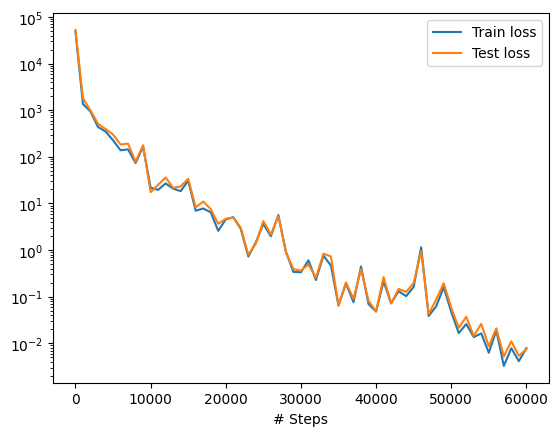

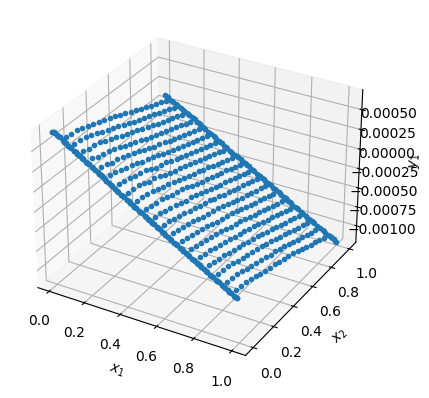

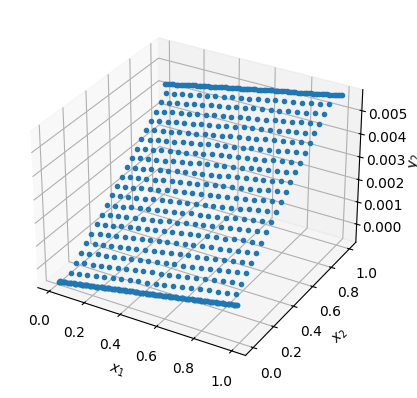

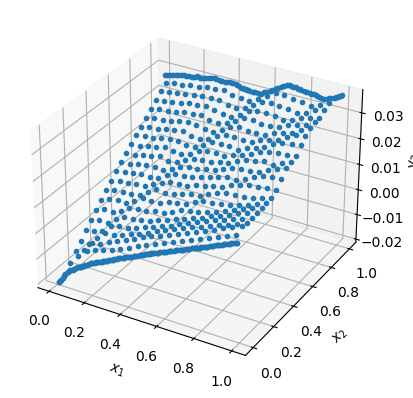

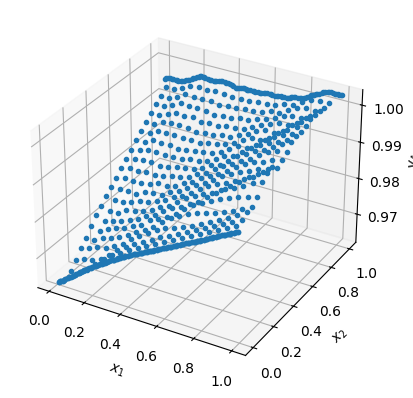

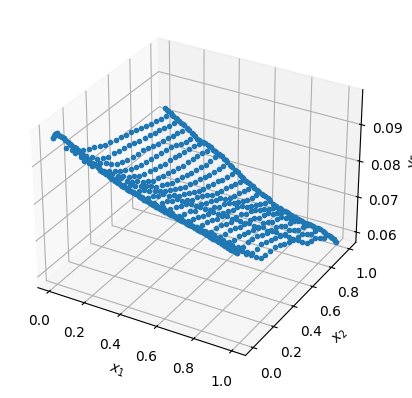

In [53]:
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
traction = 1
E = 2e2
L = 1  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Define the PDE
def pde(x, y):
    sigma_xx=y[:,2:3]
    sigma_yy=y[:,3:4]
    sigma_xy=y[:,4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 =  dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0,i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1,eq2,eq3,eq4,eq5,eq6]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
)

# Neural network
net = dde.maps.FNN([2] + [200] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam",lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


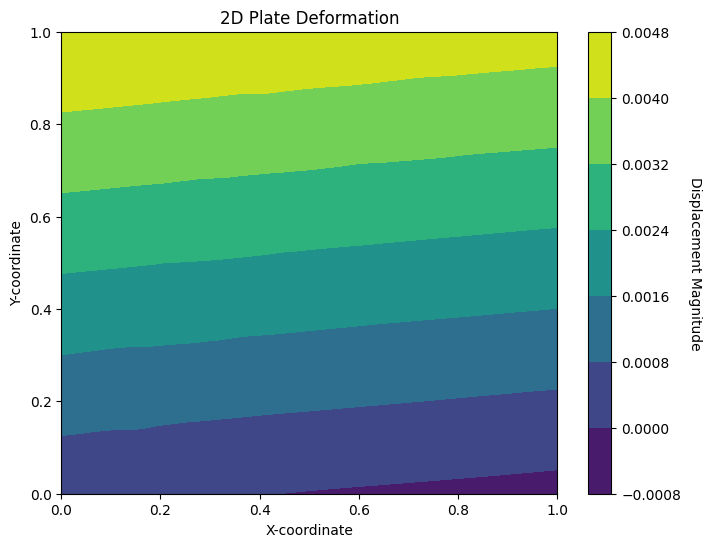

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model has already been trained
# Now you can generate test points in the geometry and evaluate the solution

# Generate a grid of points in the geometry (replace this with your actual grid)
x_test = np.linspace(0, L, 3000)  # x-coordinates
y_test = np.linspace(0, L, 3000)  # y-coordinates
x_grid, y_grid = np.meshgrid(x_test, y_test)  # Create a mesh grid

# Flatten the grid points into a list of coordinates
test_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Predict displacements using the trained model
u_pred = model.predict(test_points)

# Extract the x and y displacements from the predictions
u_x_pred = u_pred[:, 0].reshape(x_grid.shape)
u_y_pred = u_pred[:, 1].reshape(y_grid.shape)

# Compute the magnitude of the deformation at each point
deformation_magnitude =  u_y_pred

# Plotting the 2D deformation with magnitude

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot the displacement magnitude as a contour plot
contour = plt.contourf(x_grid, y_grid, deformation_magnitude, cmap='viridis')

# Add a color bar to show the magnitude of displacement
cbar = plt.colorbar(contour)
cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

# Overlay a quiver plot for displacement vectors
#plt.quiver(x_grid, y_grid, u_x_pred, u_y_pred, color='red', scale=1e-2, headwidth=3)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('2D Plate Deformation')

# Show the plot
plt.show()
